# **WhatsApp Campaign Performance Analysis**


## **Project Overview**

This notebook presents an end-to-end analysis of a WhatsApp marketing campaign. 
The objective is to transform raw message delivery logs into structured performance insights 
that support faster reporting and better targeting decisions.

The analysis focuses on evaluating delivery and engagement performance, 
segmenting results by medical specialty and ownership, 
and producing an automated, Excel-ready performance summary.

## **Background and Business Context**

WhatsApp is commonly used as a communication channel in pharmaceutical marketing 
to reach healthcare professionals (HCPs) at scale. 
Campaigns often involve sending thousands of messages across different medical specialties.

While campaign execution is automated, performance reporting is often manual. 
Raw delivery logs must be cleaned, joined with reference data, 
and transformed into meaningful metrics before insights can be generated.


## **Business Challenge**

Manual Excel-based reporting processes are time-consuming, difficult to standardize, 
and limit the ability to consistently segment results for deeper analysis. 
As campaign volume increases, these limitations make it harder to monitor performance 
and identify opportunities for improvement.


## **Goals**

The objectives of this project are to automate campaign performance reporting, streamline reporting turnaround time, and evaluate delivery and engagement outcomes using consistent funnel metrics. The analysis further examines specialty-level engagement patterns to generate insights that support improved targeting and campaign planning.

## **Setup & Helper Functions**

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib
from operator import attrgetter
pd.set_option('display.max_columns', None)
import seaborn as sns 
import glob
import os
import shutil

In [5]:
previous_sheet = 'Update Main Data'
current_sheet = 'Main Data'
current_period = '01-26'
brand_name = 'Brand1'
current_team = 'D3'
mccp_slsl = ['SLSL 2']

folder_path = r'WhatsApp Report\Data'
previous_file = 'All Campaign Report - Portfolio.xlsx'
current_file = r'Raw Data\Brand 1 WhatsApp Campaign - Portfolio.xlsx'

consent_folder = r'Data\Consent'
consent_file = 'Consent with Database_portfolio.xlsx'

graph_folder = r'Graph\'

In [3]:
# FUNCTION
def percentage(numbers):
    percent = (numbers*100).round(1)
    return percent

def specialty_cleaner(df):
    df['Specialty 1'] = df['Specialty 1'].str.replace('Doctor in Training/Resident - ','')
    df['Specialty 1'] = df['Specialty 1'].str.replace('Desease','Disease')
    df.loc[df['Specialty 1']=='Pediatric', 'Specialty 1'] = 'Pediatrics'
    df.loc[df['Specialty 1'].isin(['Dermatolog', 'Dermatology and venerology']), 'Specialty 1'] = 'Dermatology'
    df.loc[df['Specialty 1']=='E.N.T', 'Specialty 1'] = 'E.N.T.'
    df.loc[df['Specialty 1'].isin(['Area Pharmacist', 'Pharmacist', 'Associate Pharmacist']), 'Specialty 1'] = 'Pharmacy'
    return df

def pivot_percentage(df):
    df = (df.div(df['All'], axis=0) * 100).round(2)
    df = df.iloc[:-1,:-1]
    return df

def calculate_contribution(df,highlighted,other):
    contribution = percentage(df[highlighted]/(df[highlighted] + df[other]))
    return contribution

def calculate_growth(df, before, after):
    growth = percentage(np.where(df[before] != 0, (df[after] - df[before]) / df[before], df[after]/100))
    return growth

def whatsapp_performance(df,sent,delivered,opened,clicked):
    df['Delivery Rate (%)'] = percentage(df[delivered]/df[sent])
    df['Open Rate (%)'] = percentage(df[opened]/df[delivered])
    df['CTR (%)'] = percentage(df[clicked]/df[delivered])
    df['CTOR (%)'] = percentage(df[clicked]/df[opened])
    return df

def get_mdmid(link):
    start_keyword = 'mdmid='
    end_keyword = '&cc='

    start_pos = link.find(start_keyword)
    if start_pos == -1:
        return None
    else:
        start_pos += len(start_keyword)

    end_pos = link.find(end_keyword)
    if end_pos == -1:
        return None
    
    mdm_id = link[start_pos:end_pos]

    if (mdm_id.find('mdmid') != -1) or (mdm_id == None):
        mdm_id = 'INVALID'

    return mdm_id.upper()

## **Update Report Data Source**

## **Data Overview**

This analysis uses anonymized WhatsApp campaign logs and master reference data. 
The datasets are combined to enable performance analysis across key business dimensions.


## **Data Loading and Preparation**

The raw datasets are loaded and prepared for analysis, 
including standardization, filtering, and basic data validation.


In [ ]:
whatsapp_report_previous = pd.read_excel(f'{folder_path}/{previous_file}',sheet_name=previous_sheet)
whatsapp_report_current = pd.read_excel(f'{folder_path}/{current_file}')

### **Data Cleaning**

In [8]:
whatsapp_report_current['Brand'] = whatsapp_report_current['Communication Name'].str.split(',',expand=True)[2]
whatsapp_report_current['Brand'] = brand_name

whatsapp_report_current['Period'] = pd.to_datetime(whatsapp_report_current['Send At'],format='%d/%m/%Y %H:%M:%S').dt.strftime('%m-%y')

## **Campaign Funnel Metric Preparation**

In this section, message-level indicators are defined to represent each stage of the WhatsApp messaging funnel. These indicators are created by translating delivery status and interaction fields in the raw campaign data into clear funnel stages.

Specifically, this step:
- Maps raw message status fields to funnel stages (Sent, Delivered, Opened, Clicked)
- Establishes a consistent structure for evaluating campaign performance

These funnel metrics form the foundation for subsequent performance analysis and segmentation.

In [9]:
# Define message-level funnel indicators for campaign performance analysis

whatsapp_report_current['#Sent'] = 1

whatsapp_report_current['#Delivered'] = 0
whatsapp_report_current.loc[whatsapp_report_current['Status'].isin(['Delivered','Opened','Clicked']),'#Delivered'] = 1

whatsapp_report_current['#Opened'] = 0
whatsapp_report_current.loc[whatsapp_report_current['Seen At'].notna(),'#Opened'] = 1

whatsapp_report_current['#Clicked'] = 0
whatsapp_report_current.loc[whatsapp_report_current['Clicks'].notna(),'#Clicked'] = 1

## **Consent Data Integration**

This section integrates campaign message data with a reference dataset that contains consent and profile information. The purpose of this step is to enrich campaign records with additional attributes required for analysis and segmentation.

In [10]:
df_consent = pd.read_excel(f'{consent_folder}/{consent_file}', sheet_name='Full Consent')
im_consent = df_consent[df_consent['Channel']=='Instant Messaging']

In [ ]:
im_consent['MCCP'] = 'No'
im_consent.loc[im_consent['MR Full Name'].notna(), 'MCCP'] = 'Yes'

In [ ]:
whatsapp_report_current['VeevaID'] = whatsapp_report_current['VeevaID'].astype(str)
im_consent['Account Veeva ID'] = im_consent['Account Veeva ID'].astype(str)

In [13]:
whatsapp_report_full = pd.merge(
    left=whatsapp_report_current,
    right=im_consent[['Account Veeva ID', 'MDM ID', 'First Name', 'Last Name', 'Full Name', 'Specialty 1', 'Address', 'City', 'Consent Active', 'MR Full Name','FLSL/Direct Manager','SLSL/Manager Supervisor','Team','MCCP']].drop_duplicates(),
    left_on='VeevaID',
    right_on='Account Veeva ID',
    how='left'
).rename(columns={'FLSL/Direct Manager': 'Manager Full Name', 'SLSL/Manager Supervisor':'SLSL Name'})

By integrating reference data at this stage, subsequent performance analysis can be segmented consistently across relevant business dimensions without altering the underlying campaign metrics.

## **Campaign Performance Summary**

### **Target Specialty Distribution**

This section shows the distribution of campaign targets across medical specialties, providing context on how the audience was defined before evaluating performance.

In [14]:
CommunicationStartDate = whatsapp_report_current['Communication Start Date'].unique()[0]

brand_level_report = whatsapp_report_full[(whatsapp_report_full['Brand']==brand_name) & (whatsapp_report_full['Communication Start Date']==CommunicationStartDate)].copy()
brand_level_report = specialty_cleaner(brand_level_report)

In [15]:
target_specialty = brand_level_report.iloc[:,:-5].drop_duplicates(subset='VeevaID').groupby('Specialty 1')[['#Sent']].sum()
target_specialty.loc['Total'] = target_specialty.sum()
target_specialty

,#Sent
Specialty 1,
Dermatology,1040
General Practice,1858
Internal Medicine,2812
Pulmonary Disease,991
Total,6701


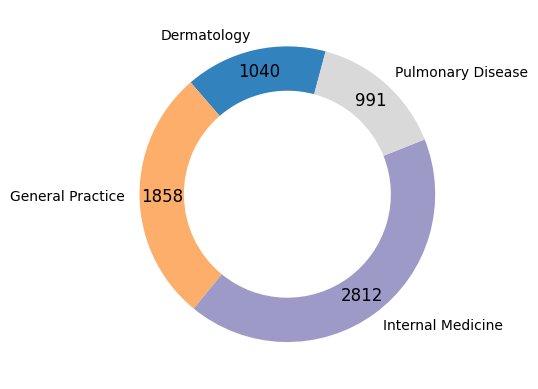

In [16]:
piechart_data = target_specialty[target_specialty['#Sent'].notna()][['#Sent']].iloc[:-1,:].astype(int)

piechart_data.plot(kind='pie', y='#Sent', colormap='tab20c', wedgeprops=dict(width=0.3), autopct='', pctdistance=0.85, legend=False,startangle=75)
 
pie_values = piechart_data['#Sent'].values
pie_labels = piechart_data.index.tolist()

angles = [angle for angle in plt.gca().patches if isinstance(angle, matplotlib.patches.Wedge)]
 
for i, (value, label, angle) in enumerate(zip(pie_values, pie_labels, angles)):
    angle_rad = np.deg2rad((angle.theta2 - angle.theta1) / 2.0 + angle.theta1)
    x = np.cos(angle_rad)
    y = np.sin(angle_rad)
    plt.annotate(f'{value}', xy=(x, y), xytext=(0.85 * x, 0.85 * y), fontsize=12, color='black', ha='center', va='center')
 
plt.gca().set_aspect('equal')
plt.gca().axis('off')
plt.ylabel('')

graph_name = f'[{current_period}] {brand_name} - Target Specialty.jpg'
graph_path = f'{graph_folder}/{graph_name}'
plt.savefig(f'{graph_path}')

plt.show()

The target audience is not evenly distributed across specialties, indicating a deliberate focus on specific groups. This reflects the campaign’s strategic intent and helps contextualize subsequent performance results.

Understanding the initial targeting mix is important, as engagement outcomes should be interpreted relative to the size and composition of each specialty segment.

### **Overall Performance**

This section provides a high-level summary of campaign delivery and engagement performance, serving as an executive overview before deeper segmentation analysis.

In [17]:
wa_status = brand_level_report[brand_level_report['Specialty 1'].notna()][
    ['Period','VeevaID','Specialty 1','Communication Name','#Sent','#Delivered','#Opened','#Clicked']].drop_duplicates(subset='VeevaID').copy()

In [18]:
overall_performance = wa_status.groupby(['Period','Communication Name'])[
    ['#Sent','#Delivered','#Opened','#Clicked']].sum()

In [19]:
overall_performance = whatsapp_performance(overall_performance,'#Sent','#Delivered','#Opened','#Clicked').reset_index().set_index('Period')
overall_performance['#Undelivered'] = overall_performance['#Sent'] - overall_performance['#Delivered']
overall_performance

,Communication Name,#Sent,#Delivered,#Opened,#Clicked,Delivery Rate (%),Open Rate (%),CTR (%),CTOR (%),#Undelivered
Period,,,,,,,,,,
04-25,"Promo,BC,Brand1,Gl_2017_10_19_03_ID,Indonesia,...",6701,5718,3389,243,85.3,59.3,4.2,7.2,983


At an overall level, the campaign achieved strong delivery performance, indicating that messages were successfully delivered to the intended audience. Engagement metrics provide a baseline understanding of how recipients interacted with the campaign content.

These results establish a reference point for evaluating performance differences across segments such as medical specialty and ownership in subsequent analyses.

### **Click-Based Engagement by Specialty**

Because WhatsApp does not consistently provide reliable “open” behavior signals, click activity is used here as the primary indicator of engagement.

This visualization compares engagement metrics across medical specialties to identify differences in how audiences responded to the campaign.

In [20]:
engagement_wa = wa_status.groupby(['Period','Communication Name','Specialty 1'])[['#Clicked']].sum()
engagement_wa

#Clicked
Period Communication Name                                 Specialty 1                
04-25  Promo,BC,Brand1,Gl_2017_10_19_03_ID,Indonesia,I... Dermatology              66
                                                          General Practice         65
                                                          Internal Medicine        78
                                                          Pulmonary Disease        34

In [21]:
clicked_message = wa_status[wa_status['Period'] == current_period].groupby(['Communication Name', 'Specialty 1'])[['#Sent', '#Delivered', '#Clicked']].sum().reset_index()
clicked_message['#Unclicked'] = clicked_message['#Delivered'] - clicked_message['#Clicked']

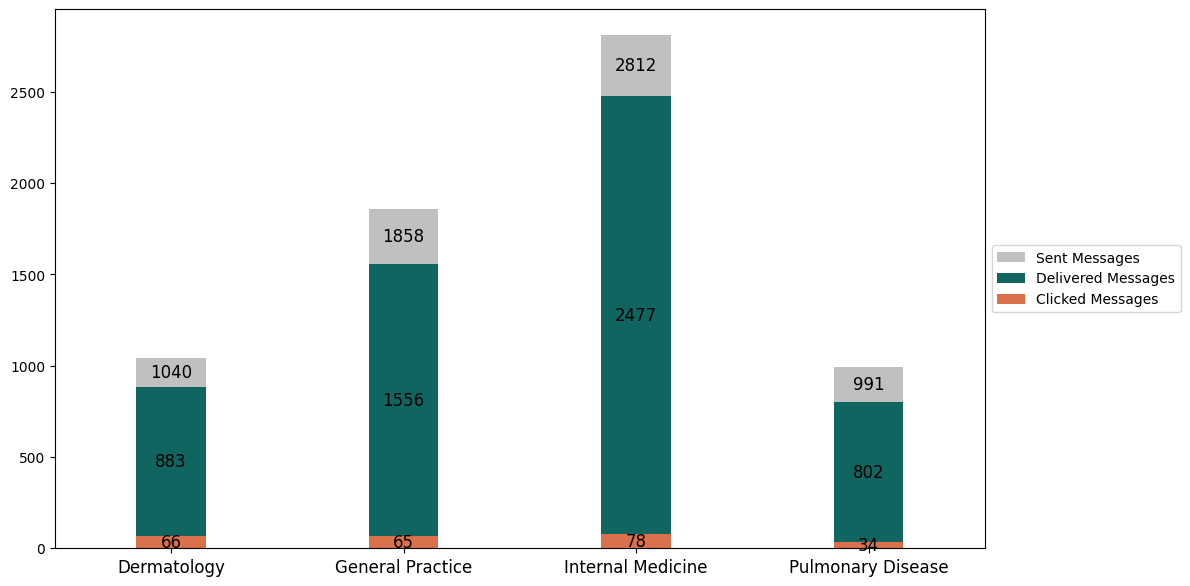

In [22]:
plt.figure(figsize=(12, 7))

sns.barplot(data=clicked_message, x='Specialty 1', y='#Sent',color='silver', width=0.3, label='Sent Messages')
sns.barplot(data=clicked_message, x='Specialty 1', y='#Delivered',color='#02736E', width=0.3, label='Delivered Messages')
sns.barplot(data=clicked_message, x='Specialty 1', y='#Clicked',color='#F36633', width=0.3, label='Clicked Messages')

# Labels: Sent
for index, row in clicked_message.iterrows():
    plt.text(index,(((row['#Sent'] - row['#Delivered']) / 2) + row['#Delivered']),f"{int(row['#Sent'])}", ha='center', va='center', fontsize=12)

# Labels: Delivered
for index, row in clicked_message.iterrows():
    plt.text(index,(((row['#Delivered'] - row['#Clicked']) / 2) + row['#Clicked']),f"{int(row['#Delivered'])}", ha='center', va='center', fontsize=12)

# Labels: Clicked
for index, row in clicked_message.iterrows():
    plt.text(index,((row['#Clicked']) / 2),f"{int(row['#Clicked'])}", ha='center', va='center', fontsize=12)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(fontsize=12, rotation=0)
plt.ylabel('')
plt.xlabel('')

graph_name = f'[{current_period}] {brand_name} - Delivered vs Clicked.jpg'
graph_path = f'{graph_folder}/{graph_name}'
plt.savefig(graph_path)

plt.show()

Across all specialties in the current period, the campaign delivered **6,214 messages**, of which **183 resulted in a click**, corresponding to an overall click rate of approximately **3.0%**.

Click activity is unevenly distributed across specialties. A small number of specialties account for a disproportionate share of total clicks, indicating higher interaction potential despite similar delivery volumes.

Among all specialties, **Dermatology** shows the highest click engagement, with a click rate of approximately **7.5%**, despite representing a smaller share of total message volume.

### **Undelivered**

In [23]:
undelivered_pivot = brand_level_report[brand_level_report['#Delivered']!=1].groupby('Error Name')[['Account Veeva ID']].nunique()
undelivered_pivot = undelivered_pivot.reset_index()
undelivered_pivot

,Error Name,Account Veeva ID
0,Account not provisioned for global one- or two...,1
1,Destination address blocked by mobile operator...,60
2,Frequency capping limit reached (code 7032),57
3,Message canceled (code 4100),865


The most significant contributor to undelivered messages in this campaign is **“Message canceled (code 4100)”**.

This status indicates that the message exceeded the delivery time limit of **2 × 24 hours** and was not successfully delivered to the HCP. In practical terms, this typically occurs when the message cannot be delivered within the allowed time window, potentially due to unstable network conditions, temporary technical disruptions, or device-level availability issues on the recipient side.

Understanding this dominant failure reason helps clarify that a portion of undelivered messages is driven by delivery constraints rather than campaign content or targeting, and should be considered when evaluating overall campaign effectiveness.

### **TOP 5 Medical Representative (by Clicked Rate)**

In [24]:
team_status = brand_level_report[(brand_level_report['Specialty 1'].notna()) 
                                  & (brand_level_report['Period']==current_period)
                                  & (brand_level_report['Team']==current_team)][
                                      ['Period','VeevaID','Communication Name','MR Full Name','Manager Full Name', 
                                       'SLSL Name','Team','#Sent','#Delivered','#Opened','#Clicked']].drop_duplicates().copy()

In [25]:
pivot_team_status = team_status.groupby(['Communication Name','MR Full Name','Manager Full Name','SLSL Name','Team'])[['#Sent','#Delivered','#Opened','#Clicked']].sum().reset_index()
pivot_team_status = whatsapp_performance(pivot_team_status,'#Sent','#Delivered','#Opened','#Clicked')

In [26]:
top_5_MR = pivot_team_status.sort_values(by='CTR (%)',ascending=False).head()
top_5_MR

,Communication Name,MR Full Name,Manager Full Name,SLSL Name,Team,#Sent,#Delivered,#Opened,#Clicked,Delivery Rate (%),Open Rate (%),CTR (%),CTOR (%)
3,"Promo,BC,Brand1,Gl_2017_10_19_03_ID,Indonesia,...",MR 122,FLSL 20,SLSL 4,D3,28,25,18,4,89.3,72.0,16.0,22.2
16,"Promo,BC,Brand1,Gl_2017_10_19_03_ID,Indonesia,...",MR 179,FLSL 30,SLSL 4,D3,14,14,8,2,100.0,57.1,14.3,25.0
8,"Promo,BC,Brand1,Gl_2017_10_19_03_ID,Indonesia,...",MR 145,FLSL 30,SLSL 4,D3,25,22,13,3,88.0,59.1,13.6,23.1
13,"Promo,BC,Brand1,Gl_2017_10_19_03_ID,Indonesia,...",MR 159,FLSL 28,SLSL 4,D3,36,33,17,4,91.7,51.5,12.1,23.5
28,"Promo,BC,Brand1,Gl_2017_10_19_03_ID,Indonesia,...",MR 61,FLSL 15,SLSL 4,D3,20,17,10,2,85.0,58.8,11.8,20.0


### **Most Undelivered Account Owner**

In [27]:
pivot_team_status['#Undelivered'] = pivot_team_status['#Sent'] - pivot_team_status['#Delivered']

In [28]:
low_5_MR = pivot_team_status.sort_values(by='#Undelivered',ascending=False).head()
low_5_MR

,Communication Name,MR Full Name,Manager Full Name,SLSL Name,Team,#Sent,#Delivered,#Opened,#Clicked,Delivery Rate (%),Open Rate (%),CTR (%),CTOR (%),#Undelivered
21,"Promo,BC,Brand1,Gl_2017_10_19_03_ID,Indonesia,...",MR 189,FLSL 28,SLSL 4,D3,35,28,16,3,80.0,57.1,10.7,18.8,7
27,"Promo,BC,Brand1,Gl_2017_10_19_03_ID,Indonesia,...",MR 6,FLSL 6,SLSL 4,D3,39,34,18,1,87.2,52.9,2.9,5.6,5
1,"Promo,BC,Brand1,Gl_2017_10_19_03_ID,Indonesia,...",MR 114,FLSL 6,SLSL 4,D3,36,31,19,1,86.1,61.3,3.2,5.3,5
22,"Promo,BC,Brand1,Gl_2017_10_19_03_ID,Indonesia,...",MR 20,FLSL 17,SLSL 4,D3,37,32,17,1,86.5,53.1,3.1,5.9,5
24,"Promo,BC,Brand1,Gl_2017_10_19_03_ID,Indonesia,...",MR 33,FLSL 6,SLSL 4,D3,24,19,10,0,79.2,52.6,0.0,0.0,5


### **Brand Focus Summary**

In [29]:
brand_summary = brand_level_report[(brand_level_report['Specialty 1'].notna()) 
                                  & (brand_level_report['Period']==current_period)
                                  & (brand_level_report['SLSL Name'].isin(mccp_slsl))][['VeevaID','MR Full Name','Manager Full Name', 
                                   'SLSL Name','Team','#Sent','#Delivered','#Opened','#Clicked']].drop_duplicates(subset='VeevaID').copy()

In [30]:
pivot_brand_summary = brand_summary.groupby(['SLSL Name', 'Manager Full Name','Team','MR Full Name'])[['#Sent', '#Delivered', '#Opened', '#Clicked']].sum()

In [31]:
sum_brand_summary = pivot_brand_summary.sum()
sum_brand_summary

#Sent         978
#Delivered    850
#Opened       490
#Clicked       18
dtype: int64

In [32]:
brand_total_row = pd.DataFrame(
    sum_brand_summary.values.reshape(1,-1),
    columns=sum_brand_summary.index,
    index=pd.MultiIndex.from_tuples([('Total', '', '', '')], names=['SLSL Name', 'Manager Full Name', 'Team', 'MR Full Name'])
)

In [33]:
pivot_brand_summary = pd.concat([pivot_brand_summary, brand_total_row], axis=0)
pivot_brand_summary['#Undelivered'] = pivot_brand_summary['#Sent'] - pivot_brand_summary['#Delivered']

In [34]:
pivot_brand_summary = whatsapp_performance(pivot_brand_summary,'#Sent','#Delivered','#Opened','#Clicked')
pivot_brand_summary = pivot_brand_summary.fillna(0).reset_index()

### **MCCP/Non MCCP Summary**

#### MCCP

In [35]:
mccp_summary = brand_level_report[(brand_level_report['Specialty 1'].notna()) 
                                  & (brand_level_report['Period']==current_period)
                                  & (brand_level_report['SLSL Name'].isin(mccp_slsl))][['VeevaID','MR Full Name','Manager Full Name', 
                                   'SLSL Name','Team','#Sent','#Delivered','#Opened','#Clicked']].drop_duplicates(subset='VeevaID').copy()

In [36]:
pivot_slsl = mccp_summary.groupby(['SLSL Name', 'Manager Full Name','Team'])[['#Sent', '#Delivered', '#Opened', '#Clicked']].sum()

In [37]:
pivot_slsl

#Sent  #Delivered  #Opened  #Clicked
SLSL Name Manager Full Name Team                                      
SLSL 2    FLSL 12           D2      143         127       63         4
          FLSL 14           D2      215         184      113         8
          FLSL 18           D2      146         126       71         1
          FLSL 3            D2      145         119       73         1
          FLSL 32           D2        4           4        1         0
          FLSL 8            D2      179         164       86         1
          FLSL 9            D2      146         126       83         3

In [38]:
sum_all = pivot_slsl.sum()
sum_all

#Sent         978
#Delivered    850
#Opened       490
#Clicked       18
dtype: int64

In [39]:
total_row = pd.DataFrame(
    sum_all.values.reshape(1,-1),
    columns=sum_all.index,
    index=pd.MultiIndex.from_tuples([('Total', '', '')], names=['SLSL Name', 'Manager Full Name', 'Team'])
)

In [40]:
pivot_slsl = pd.concat([pivot_slsl, total_row], axis=0)
pivot_slsl['#Undelivered'] = pivot_slsl['#Sent'] - pivot_slsl['#Delivered']

In [41]:
pivot_slsl = whatsapp_performance(pivot_slsl,'#Sent','#Delivered','#Opened','#Clicked')
pivot_slsl = pivot_slsl.reset_index()

In [42]:
pivot_slsl

,SLSL Name,Manager Full Name,Team,#Sent,#Delivered,#Opened,#Clicked,#Undelivered,Delivery Rate (%),Open Rate (%),CTR (%),CTOR (%)
0,SLSL 2,FLSL 12,D2,143,127,63,4,16,88.8,49.6,3.1,6.3
1,SLSL 2,FLSL 14,D2,215,184,113,8,31,85.6,61.4,4.3,7.1
2,SLSL 2,FLSL 18,D2,146,126,71,1,20,86.3,56.3,0.8,1.4
3,SLSL 2,FLSL 3,D2,145,119,73,1,26,82.1,61.3,0.8,1.4
4,SLSL 2,FLSL 32,D2,4,4,1,0,0,100.0,25.0,0.0,0.0
5,SLSL 2,FLSL 8,D2,179,164,86,1,15,91.6,52.4,0.6,1.2
6,SLSL 2,FLSL 9,D2,146,126,83,3,20,86.3,65.9,2.4,3.6
7,Total,,,978,850,490,18,128,86.9,57.6,2.1,3.7


#### Non MCCP

In [43]:
non_mccp_summary = brand_level_report[(brand_level_report['Specialty 1'].notna()) 
                                  & (brand_level_report['Period']==current_period)
                                  & (~brand_level_report['SLSL Name'].isin(mccp_slsl))
                                  & (~brand_level_report['VeevaID'].isin(mccp_summary['VeevaID']))][['VeevaID','MR Full Name','Manager Full Name', 
                                   'SLSL Name','Team','#Sent','#Delivered','#Opened','#Clicked']].drop_duplicates(subset='VeevaID').copy()

In [44]:
pivot_non_mccp = non_mccp_summary[['#Sent', '#Delivered', '#Opened', '#Clicked']].sum()

In [45]:
pivot_non_mccp['#Undelivered'] = pivot_non_mccp['#Sent'] - pivot_non_mccp['#Delivered']
pivot_non_mccp = whatsapp_performance(pivot_non_mccp,'#Sent','#Delivered','#Opened','#Clicked')
pivot_non_mccp = pivot_non_mccp.to_frame().T

In [46]:
pivot_non_mccp

,#Sent,#Delivered,#Opened,#Clicked,#Undelivered,Delivery Rate (%),Open Rate (%),CTR (%),CTOR (%)
0,5723.0,4868.0,2899.0,225.0,855.0,85.1,59.6,4.6,7.8


## **Save Report**

In [47]:
whatsapp_report = pd.concat([whatsapp_report_previous,whatsapp_report_current],ignore_index=True).drop_duplicates()

# Save DataFrame to Excel 
file_name = 'All Campaign Report - Portfolio.xlsx'
file_path = f'{folder_path}/{file_name}'

with pd.ExcelWriter(file_path) as writer:
    whatsapp_report.to_excel(writer, sheet_name=f'Update {current_sheet}', index=False)
    whatsapp_report_previous.to_excel(writer, sheet_name='Previous Data', index=False)

In [48]:
# Save DataFrame to Excel 

file_name = f'[{current_period}] - {brand_name} - WhatsApp Report.xlsx'
file_path = f'{folder_path}/{file_name}'

with pd.ExcelWriter(file_path) as writer:
    target_specialty.reset_index().to_excel(writer, sheet_name='Audience by Specialty', index=False)
    overall_performance.reset_index().to_excel(writer, sheet_name='Overall Performance', index=False)
    engagement_wa.reset_index().to_excel(writer, sheet_name='Engagement per Specialty', index=False)
    clicked_message.to_excel(writer, sheet_name='Clicked Message per Specialty', index=False)
    undelivered_pivot.to_excel(writer, sheet_name='Undelivered Reason', index=False)
    top_5_MR.to_excel(writer, sheet_name='Top 5 MedReps', index=False)
    low_5_MR.to_excel(writer, sheet_name='Low 5 MedReps', index=False)
    pivot_team_status.to_excel(writer, sheet_name='All MR Performance', index=False)
    pivot_slsl.to_excel(writer, sheet_name='MCCP Summary', index=False)
    pivot_non_mccp.to_excel(writer, sheet_name='Non MCCP Summary', index=False)
    pivot_brand_summary.to_excel(writer, sheet_name='SLSL Summary', index=False)

## **Key Insights**

- Campaign delivery performance was generally strong; however, a measurable portion of messages was not successfully delivered. The dominant undelivered reason was **“Message canceled (code 4100)”**, indicating that messages exceeded the 2 × 24 hour delivery window. This suggests delivery constraints rather than content or targeting issues.

- Click-based engagement is used as a more reliable indicator of interaction. Although absolute click volumes are relatively small, the resulting click-through rate exceeds the **1% benchmark**, demonstrating that the campaign generated meaningful interaction when evaluated using a conservative engagement metric.

- Click engagement varies across medical specialties, highlighting differences in audience responsiveness. Some specialties show stronger interaction despite representing a smaller share of total message volume.

- Separating delivery limitations from engagement behavior allows for a more accurate interpretation of campaign performance and supports more focused optimization in future WhatsApp campaigns.

## **Business Impact**

The workflow demonstrated in this analysis streamlines campaign reporting by replacing manual Excel processes with a repeatable analytical approach, significantly reducing reporting time and effort.

By reviewing delivery outcomes and click activity separately, the analysis provides clearer insight into campaign performance and supports more informed decisions around targeting, messaging, and operational follow-up in future campaigns.